                  2409
Returns       0.119639
Volatility    0.102736
Sharpe Ratio  1.164526
1101 Weight   0.028277
1102 Weight   0.013797
1216 Weight   0.227396
1301 Weight   0.178414
1303 Weight   0.552116
                  1715
Returns       0.163333
Volatility    0.116827
Sharpe Ratio  1.398068
1101 Weight   0.349714
1102 Weight   0.220555
1216 Weight   0.001948
1301 Weight   0.100157
1303 Weight   0.327626


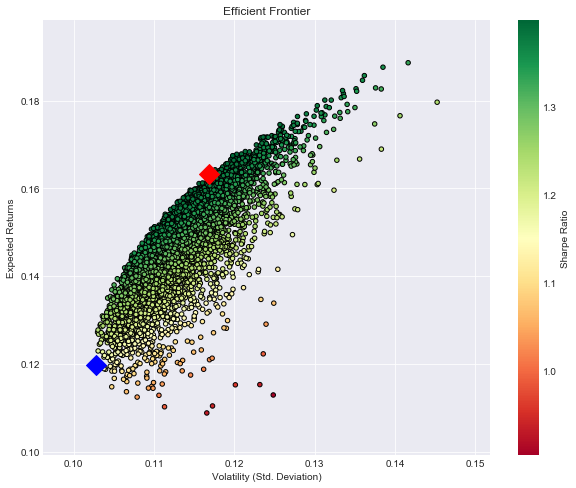

       Returns  Volatility  Sharpe Ratio  1101 Weight  1102 Weight  \
1715  0.163333    0.116827      1.398068     0.349714     0.220555   

      1216 Weight  1301 Weight  1303 Weight  
1715     0.001948     0.100157     0.327626  


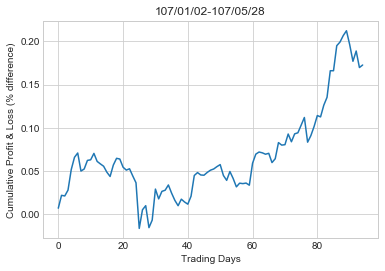

                 1715
1101 Weight  0.349714
1102 Weight  0.220555
1216 Weight  0.001948
1301 Weight  0.100157
1303 Weight  0.327626
               0
Return  0.165543
SD      0.052213


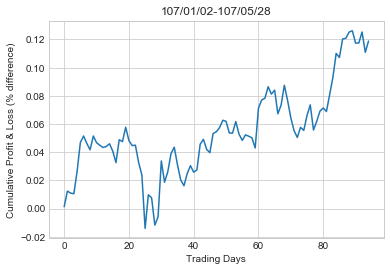

                 2409
1101 Weight  0.028277
1102 Weight  0.013797
1216 Weight  0.227396
1301 Weight  0.178414
1303 Weight  0.552116
               0
Return  0.117476
SD      0.031596


In [4]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt

import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

# read one stock from excel and create dataframe 
def read_clean_stock_from_excel(stock):
    # reading from excel 
    df = pd.read_excel(str(stock) + '.xlsx', sheetname=str(stock))

    # dropping unwanted columns and renaming to english 
    df.drop(['成交股數', '成交金額', '最高價', '開盤價', '最低價', '漲跌價差', '成交筆數'], axis=1, inplace=True)
    df.columns=['date','closing_price']

    # Adding a column of the stock number to the dataframe 
    stock_no = []
    for i in range(len(df['date'])):
        stock_no.append(str(stock))

    df['stock_no'] = stock_no
    
    return df
    

# concatenate 5 stocks into one dataframe
def concatenate_process_5_stocks(stock_list):
    # add dataframes to df_list
    df_list = []
    for stock in stock_list:
        df_list.append(read_clean_stock_from_excel(stock))   
    
    # concat df of different stocks 
    final_df = df_list[0]
    
    for i in range(1, len(df_list)):
        final_df = final_df.append(df_list[i])
    
    # reorganise data pulled by setting date as index with
    # columns of stock_no and their corresponding closing_prices
    clean = final_df.set_index('date')
    #print(clean)
    table = clean.pivot(index=clean.index, columns='stock_no')
    #table.head()
    
    
    # calculate daily and annual returns of the stocks
    returns_daily = table.pct_change() # Percentage change between the current and a prior element.
    returns_annual = returns_daily.mean() * len(table) #trading days

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * len(table)

    # empty lists to store returns, volatility and weights of imaginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(stock_list)
    num_portfolios = 5000


    #set random seed for reproduction's sake
    np.random.seed(101)


    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        returns = np.dot(weights, returns_annual)
        
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights))) #SD
        
        rf_rate = 0.00 # risk free rate of return
        
        sharpe = (returns - rf_rate)/ volatility
        
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter,stock in enumerate(stock_list):
        portfolio[str(stock)+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [str(stock)+' Weight' for stock in stock_list]

    # reorder dataframe columns
    df = df[column_order]
    
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()

    # use the min, max values to locate and create the two special portfolios
    # df.loc --> Access a group of rows and columns by label(s) or a boolean array.
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe] 
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    
    # print the details of the 2 special portfolios
    print(min_variance_port.T)
    print(sharpe_portfolio.T)
    
    # The most risk-averse investor would construct the minimum variance portfolio
    # which has an expected return of 11.96% with an accompanying expected volatility of 10.27%. 

    # Investors seeking the maximum risk-adjusted return would opt for portfolio that with 
    # the maximum Sharpe Ratio which has an expected return of 16.33% with expected volatility pegged at 11.68%
    
    
    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-dark')
    fig, ax = plt.subplots()
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True, ax=ax)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200)
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    plt.show()
    
    
    

    # Calculate Cumulative Returns
    # (Current Price of Security - Original Price of Security) / (Original Price of Security)
    # SAME AS    Percentage change from initial value = (current value/initial value) - 1
    CR = final_df.set_index('date') # Copy table without aliasing
    # Pivot table 
    
    CR_table = CR.pivot(index=clean.index, columns='stock_no')
    # Drop closing_price header for easier deletion of columns 
    CR_table = CR_table.xs('closing_price', axis=1, drop_level=True)
    # Reset index of dataframe 
    CR_table.reset_index(inplace=True)
    # delete column dates of dataframe 
    CR_table.drop(['date'], axis=1, inplace=True)
    
    # Adding the Cumulative Returns to each stock
    # Percentage change from initial value = (current value/initial value) - 1
    for i in range(len(stock_list)):
        CR_table[CR_table.columns[i] +' pct_diff'] = \
        (CR_table[CR_table.columns[i]]).astype(float) / int(CR_table[CR_table.columns[i]].iat[0]) - 1
    
    # Removing the closing_prices columns
    for stock in stock_list:
        CR_table.drop([str(stock)], axis=1, inplace=True)
    
    # Using weights from Maximum Sharpe Ratio 
    # Remove unwanted rows from optimal Sharpe_portfolio
    sharpe_p = sharpe_portfolio.copy()
    sharpe_p.drop(['Returns', 'Volatility', 'Sharpe Ratio'], axis=1, inplace=True)
    # Create list of weights 
    sharpe_list = sharpe_p.as_matrix()[0]
     
    # Create list of column names
    pct_diff_stock_list = []
    for stock in stock_list:
        pct_diff_stock_list.append(str(stock) + ' pct_diff')
        
    # Multiple by the portfolio's weights to get sum of profits/losses for that day  
    CR_table['sharpe_weighted'] = CR_table[pct_diff_stock_list].mul(sharpe_list).sum(1) # axis=1 
    
    # Plotting Performance Chart: x-axis is dates, y-axis is returns
    # Plot Cumulative Profit and Loss vs Trading Days   
    # print(plt.style.available) <-- to check styles available for graph 
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots()
    ax.plot(CR_table.index, CR_table['sharpe_weighted'])
    plt.xlabel('Trading Days')
    plt.ylabel('Cumulative Profit & Loss (% difference)')
    plt.title(str(table.index[0]) + '-' + str(table.index[-1]))
    plt.show() 
    
    print(sharpe_p.T)
    
    # Create dataframe to show return and SD for max_sharpe portfolio
    sharpe_rtn = (CR_table['sharpe_weighted'][len(CR_table['sharpe_weighted'])-1] - CR_table['sharpe_weighted'][0])
    sharpe_std = CR_table['sharpe_weighted'].std()
    sharpe_mean_SD = pd.DataFrame([sharpe_rtn, sharpe_std], index = ['Return', 'SD'])
    print(sharpe_mean_SD)
    
    
    
    #Using weights from Minimum Volatility 
    min_volat = min_variance_port.copy()
    min_volat.drop(['Returns', 'Volatility', 'Sharpe Ratio'], axis=1, inplace=True)
    # Create list of weights
    volat_list = min_volat.as_matrix()[0]
    
    
    # Create list of column names
    pct_diff_stock_list = []
    for stock in stock_list:
        pct_diff_stock_list.append(str(stock) + ' pct_diff')
        
    # Multiple by the portfolio's weights to get sum of profits/losses for that day  
    CR_table['volat_weighted'] = CR_table[pct_diff_stock_list].mul(volat_list).sum(1)
    
    # Plotting Performance Chart: x-axis is dates, y-axis is returns
    # Plot Cumulative Profit and Loss vs Trading Days   
    # print(plt.style.available) <-- to check styles available for graph 
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots()
    ax.plot(CR_table.index, CR_table['volat_weighted'])
    plt.xlabel('Trading Days')
    plt.ylabel('Cumulative Profit & Loss (% difference)')
    plt.title(str(table.index[0]) + '-' + str(table.index[-1]))
    plt.show() 
    
    print(min_volat.T)
    
    # Create dataframe to show return and SD for min_volat portfolio  
    volat_rtn = (CR_table['volat_weighted'][len(CR_table['volat_weighted'])-1] - CR_table['volat_weighted'][0])
    volat_std = CR_table['volat_weighted'].std()
    volat_mean_SD = pd.DataFrame([volat_rtn, volat_std], index = ['Return', 'SD'])
    print(volat_mean_SD)




stock_list = [1101, 1102, 1216, 1301, 1303]
concatenate_process_5_stocks(stock_list)



